# Marketing Analytics group project

**1. Data Preparation**

**2. Exploring the content of variables**

   - 2.1 Countries
   - 2.2 Customers and products
       * 2.2.1 Cancelling orders
       * 2.2.2 StockCode
       * 2.2.3 Basket price

**3.Product segmentation using clustering**

   - 3.1 Product description 
   - 3.2 Defining product categories 
       * 3.2.1 Data encoding
       * 3.2.2 Clusters of products
       * 3.2.3 Characterizing the content of clusters
   
**4. Customer segmentation using clustering**

   - 4.1 Formating data
       * 4.1.1 Grouping products 
       
       * 4.1.2 Grouping orders 
   - 4.2 Creating customer categories
       * 4.2.1 Data enconding
       * 4.2.2 Creating categories

**5. RFM analysis**

## 1. Data preparation

As a first step, I load all the modules that will be used in this notebook:

In [ ]:
#need to install these libraries the first time you run the notebook
# %pip install --user -U nltk
# %conda install -c conda-forge wordcloud
# %conda install -c plotly plotly
# %pip install pandas-profiling

In [ ]:
#%conda update -n base -c defaults conda

In [2]:
import pandas as pd
from datetime import datetime


import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.cm as cm
import itertools
import pandas_profiling
import plotly.graph_objs as go

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from datetime import datetime
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/markouskokovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/markouskokovic/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [515]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

## Import the data & basic info

In [4]:
# import data
data = pd.read_csv('/Users/markouskokovic/Desktop/Fall 2020/DSO 528/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})

In [6]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850,United Kingdom


In [5]:
# info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [7]:
# change invoicedate col to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [8]:
# size
data.shape

(541909, 8)

* We have almost 550K rows and 8 columns

In [15]:
# check for null values

data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
### Let's just see how rows with no customerID looks like

In [17]:
data_no_cust_id = data.loc[data['CustomerID'].isna()]

In [18]:
data_no_cust_id.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


### Since our goal is segment customers for email campaign efforts it is crucial to have customerID for further analysis, therefore we will drop all rows that have no value in customerID column

* We will keep the data with no customerID for future efforts...

In [21]:
# drop rows with no custumerID

data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [22]:
# check again for null values

data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [23]:
# check with how much data we are working now

data.shape

(406829, 8)

In [89]:
# check for duplicates and see rows if any
print(data.duplicated().sum())

data.drop_duplicates(inplace = True)

5225


___
## 2. Exploring the content of fields

This dataframe contains 8 fields that correspond to: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

___
### 2.1 Countries

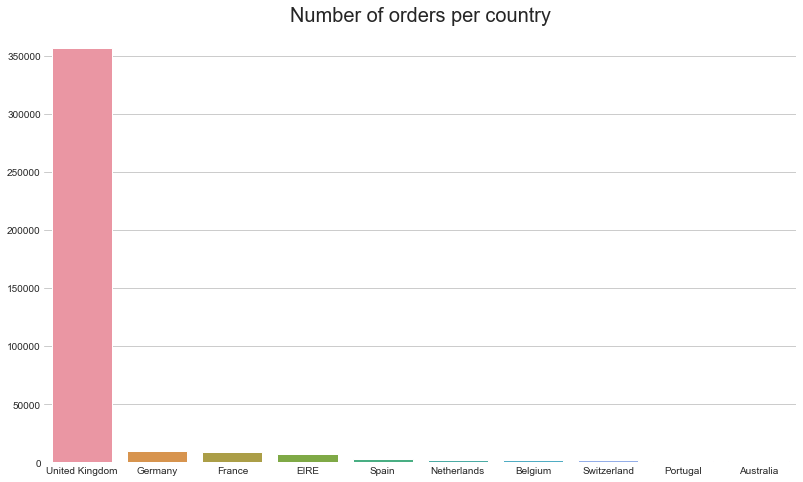

In [90]:
plt.figure(figsize = (12,8))
sns.set_style("whitegrid")

sns.barplot(data['Country'].value_counts().index[:10], data['Country'].value_counts().values[:10])
plt.title('Number of orders per country', fontsize = 20)

sns.despine(left = True, bottom = True)

We see that the dataset is largely dominated by orders made from the UK.

___
### 2.2 Customers and products

The dataframe contains about 400K entries. What are the number of users and products in these entries ?

In [91]:
pd.DataFrame([{'products': len(data['StockCode'].value_counts()),    
               'transactions': len(data['InvoiceNo'].value_counts()),
               'customers': len(data['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


* It can be seen that the data has 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of $\sim$22'000.


### Let's take a look at number of products purchased in every transaction:

In [92]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The first lines of this list shows several things worthy of interest:
- the existence of entries with the prefix C for the **InvoiceNo** variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order

### 2.2.1 Cancelling orders 


First of all, I count the number of transactions corresponding to canceled orders:

In [225]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


We note that the number of cancellations is quite large ($\sim$16% of the total number of transactions).
Now, let's look at the first lines of the dataframe:

In [226]:
data.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


On these few lines, we see that when an order is canceled, we have another transaction in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries.
To do this, I decide to locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (**CustomerID**, **Description** and **UnitPrice**):

In [227]:
df_check = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a  '_Discount_' entry. I check again the hypothesis but this time discarding the '_Discount_' entries:

In [228]:
df_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [229]:
# try to match all cancellation orders with all previous purchase orders
cancels=data[(data['Description']!='Discount')&(data['Quantity']<0)].copy()
cancels['cancel_idx']=cancels.index
df_match=data.copy()
df_match['match_idx']=df_match.index
df_match=df_match[df_match['Quantity']>0]
mg=cancels.merge(df_match[['InvoiceDate','CustomerID','StockCode','Quantity','match_idx']],how='left',
              left_on=['CustomerID','StockCode'],right_on=['CustomerID','StockCode'])
matched=mg[mg['InvoiceDate_x']>mg['InvoiceDate_y']]
matched['match_idx']=matched['match_idx'].astype(int)
matched['Quantity_y']=matched['Quantity_y'].astype(int)
# sort data to make sure matching starts with the latest purchase order
matched=matched.sort_values(['cancel_idx','InvoiceDate_y'],ascending=[1,0])

In [230]:
# since one purchase order can be matched to multiple cancellation orders,
# it can happen that one purchase order is accounted for too many cancellation orders
# e.g. the purchase order only listed 8 units in quantity, 
# but is used to match multiple cancallation orders of which the quantities sum up to more than 8
# in other words, this purchase order is double counted
# the following codes handle this problem
count=1
while True:
    # if a customer returns items that were bought through multiple purchases
    # start accounts for the returned quantity from the latest order
    # until all returned/canceled quantity is accounted for and linked to a purchase order
    # it is possible that not all the canceled quantity can be accounted for
    matched['tot_bought']=matched.groupby('cancel_idx')['Quantity_y'].cumsum()
    matched['tot_bought_lag1']=matched.groupby('cancel_idx')['tot_bought'].shift(1).fillna(0)
    matched['QuantityCanceled']=matched[['Quantity_x','Quantity_y','tot_bought','tot_bought_lag1']].\
                                 apply(lambda x: min(-x[0],x[1]) if x[3]==0 else \
                                       (x[1] if x[2]<=-x[0] else \
                                       (0 if x[3]>=-x[0] else -x[0]-x[3])), axis=1).astype(int)
    # add a column to track the total quantity a given purchae order has been used to account for a cancellation
    # if the total quantity counted exceeds the number of units that were bought in this order
    # remove this purchase order from the candidate lists of all cancellation orders from this point on
    # iterate one more time to link cancellations to purchases
    matched['tot_QuantityCanceled']=matched.groupby('match_idx')['QuantityCanceled'].cumsum()
    double_count=len(matched[matched['tot_QuantityCanceled']>matched['Quantity_y']])
    print('Iteration {} double counted: {} times'.format(count, double_count))
    if double_count>0:
        matched=matched[matched['tot_QuantityCanceled']<=matched['Quantity_y']]
        count+=1
    else:
        print('End iteration')
        break

Iteration 1 double counted: 96 times
Iteration 2 double counted: 10 times
Iteration 3 double counted: 4 times
Iteration 4 double counted: 3 times
Iteration 5 double counted: 2 times
Iteration 6 double counted: 0 times
End iteration


In [231]:
tot_canceled=matched.groupby('cancel_idx')['Quantity_x'].mean()*(-1)
tot_bought=matched.groupby('cancel_idx')['Quantity_y'].sum()
# some but not all units of the cancellation are accounted for and linked to purchase orders
partial_doubtful_entry=tot_canceled[tot_canceled>tot_bought].index.tolist()
# all units of the cancellation are accounted for and linked to purchase orders
entry_to_remove=tot_canceled[tot_canceled<=tot_bought].index.tolist()
# no previous purchase that match the cancellation can be found
doubtful_entry=list(set(mg['cancel_idx'].unique())-set(partial_doubtful_entry)-set(entry_to_remove))

In [232]:
df_cleaned = data.copy(deep = True)
df_cleaned=df_cleaned.merge(pd.DataFrame(matched[['match_idx','tot_QuantityCanceled']].groupby('match_idx').max()),
                            how='left',left_index=True, right_index=True)
df_cleaned.rename(columns={'tot_QuantityCanceled':'QuantityCanceled'},inplace=True)
df_cleaned['QuantityCanceled']=df_cleaned['QuantityCanceled'].fillna(0).astype(int)

In [233]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new field in the dataframe that indicates if part of the order has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database). Below, I make a census of the canceled orders and check for the existence of counterparts:

In [234]:
print(f"Entry_to_remove: {len(entry_to_remove)} ({len(entry_to_remove)/len(df_initial)*100:.2f}%)")
print(f"Doubtful_entry: {len(doubtful_entry)} ({len(doubtful_entry)/len(df_initial)*100:.2f}%)")
print(f"Partial_doubtful_entry: {len(partial_doubtful_entry)} ({len(partial_doubtful_entry)/len(df_initial)*100:.2f}%)")

Entry_to_remove: 7476 (1.38%)
Doubtful_entry: 1267 (0.23%)
Partial_doubtful_entry: 52 (0.01%)


* We will remove all of them...

In [235]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
df_cleaned.drop(partial_doubtful_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]

In [262]:
# Output a profile of the cleaned data
profile = pandas_profiling.ProfileReport(df_cleaned)
profile.to_file('M.A.cleaned.html')

## Before proceeding take a look at the report... I'll share with you html you can open and see what's going on

### You can see there all the basic info about data like orders per country, unique counties, unique customerID,...


# Let's take a look at purchases per month, day, hour

* this might lead us to conclusion about some trends and when is the best time for email marketing campaign

In [237]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

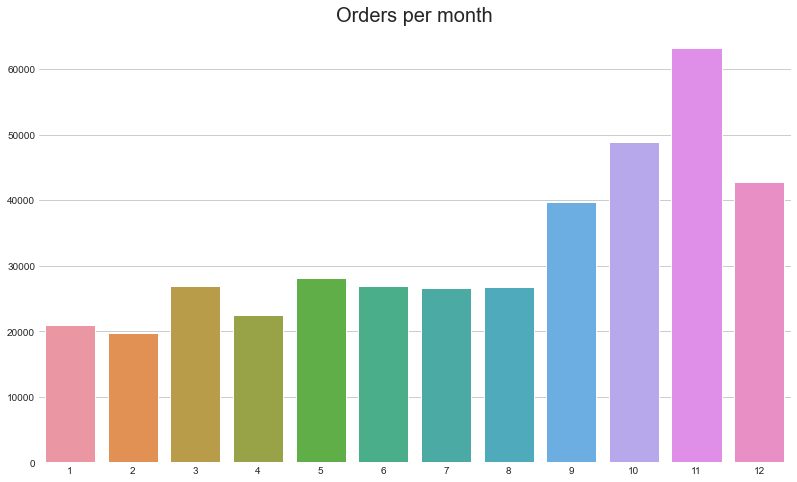

In [238]:
# orders per month

plt.figure(figsize = (12, 8))

sns.barplot(df_cleaned['Month'].value_counts().index, df_cleaned['Month'].value_counts().values)
plt.title('Orders per month', fontsize = 20)

sns.despine(left = True, bottom = True)

In [435]:
november = df_cleaned.loc[df_cleaned['Month'] == 11]

In [445]:
december = df_cleaned.loc[df_cleaned['Month'] == 12]

In [446]:
december.Day.value_counts().sort_index()

1     4003
2     3889
3     1076
4     1879
5     5914
6     4381
7     3218
8     4398
9     2332
10    1355
12    1380
13    1258
14    1592
15    1275
16    1647
17     706
19     472
20     822
21     393
22     215
23     331
Name: Day, dtype: int64

In [437]:
november.Day.value_counts().sort_index()

1     1699
2     1731
3     1919
4     2399
6     3333
7     1702
8     2242
9     2130
10    3090
11    2348
13    2683
14    2842
15    2134
16    2661
17    2927
18    2093
20    2998
21    2289
22    2740
23    3207
24    2369
25    1640
27    2344
28    2701
29    2636
30    2092
Name: Day, dtype: int64

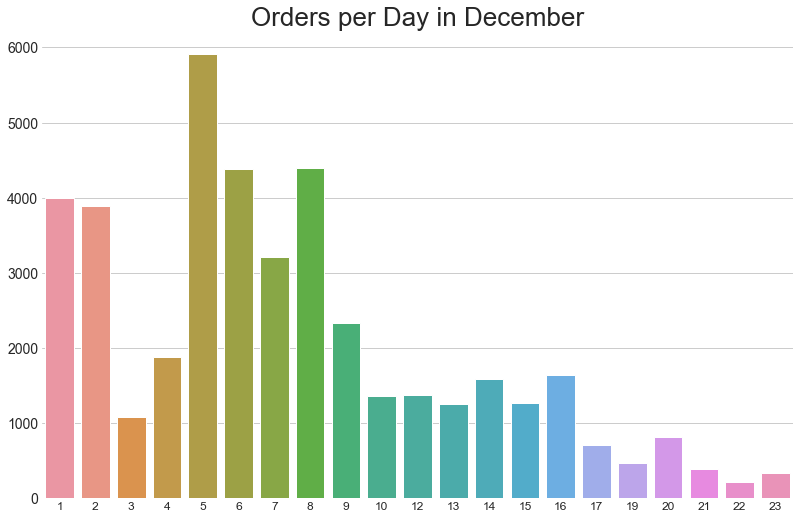

In [454]:
# orders per day

plt.figure(figsize = (12, 8))
sns.set_style('whitegrid')
sns.barplot(december.Day.value_counts().index, december.Day.value_counts().values)
plt.title('Orders per Day in December', fontsize = 26)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)



sns.despine(left = True, bottom = True)

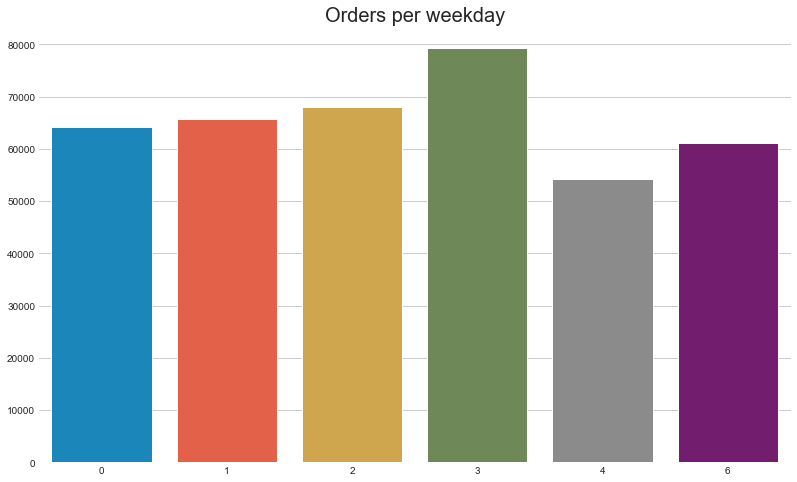

In [239]:
# orders per weekday

plt.figure(figsize = (12, 8))

sns.barplot(df_cleaned['Weekday'].value_counts().index, df_cleaned['Weekday'].value_counts().values)
plt.title('Orders per weekday', fontsize = 20)

sns.despine(left = True, bottom = True)

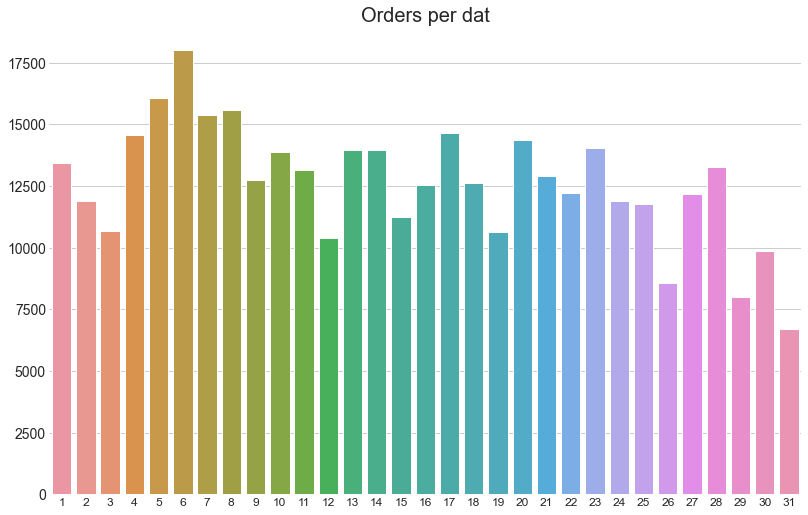

In [455]:
# orders per day

plt.figure(figsize = (12, 8))

sns.barplot(df_cleaned['Day'].value_counts().index, df_cleaned['Day'].value_counts().values)
plt.title('Orders per dat', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)

sns.despine(left = True, bottom = True)

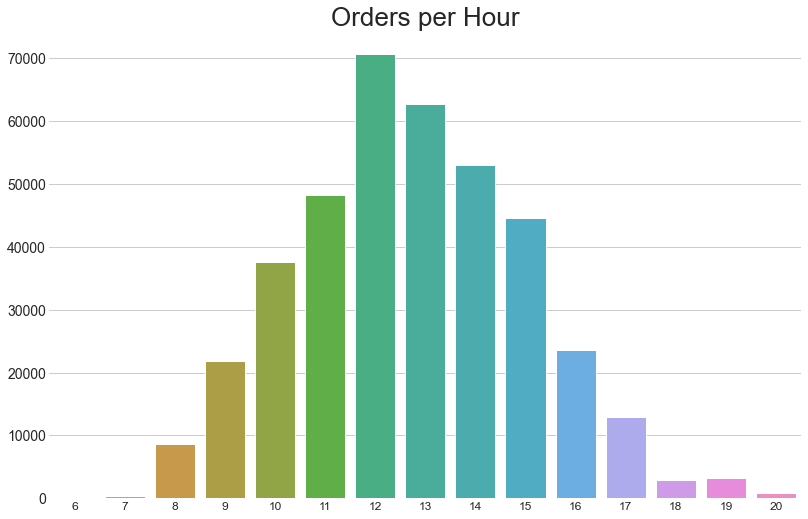

In [457]:
# orders per hour

plt.figure(figsize = (12, 8))

sns.barplot(df_cleaned['Hour'].value_counts().index, df_cleaned['Hour'].value_counts().values)
plt.title('Orders per Hour', fontsize = 26)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
sns.despine(left = True, bottom = True)

### 2.2.2 StockCode

- Check the contents of this field by looking for the set of codes that would contain only letters:

In [242]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [243]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


In [244]:
print("Number of entries with a peculiar stock code is {}".format(len(df_cleaned[df_cleaned['StockCode'].isin(list_special_codes)])))

Number of entries with a peculiar stock code is 1626


- For purposes of our analysis we will exclude rows with peculiar stock code

In [245]:
df_cleaned=df_cleaned[-df_cleaned['StockCode'].isin(list_special_codes)]


### 2.2.3 Basket Price

I create a new field that indicates the total price of every purchase:

In [246]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Month,Weekday,Day,Hour,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,1,1,18,10,0.0
286626,562032,22371,AIRLINE BAG VINTAGE TOKYO 78,8,2011-08-02 08:48:00,4.25,12347,Iceland,0,8,1,2,8,34.0
428996,573511,23308,SET OF 60 VINTAGE LEAF CAKE CASES,24,2011-10-31 12:25:00,0.55,12347,Iceland,0,10,0,31,12,13.2
428997,573511,84991,60 TEATIME FAIRY CAKE CASES,24,2011-10-31 12:25:00,0.55,12347,Iceland,0,10,0,31,12,13.2
428998,573511,84992,72 SWEETHEART FAIRY CAKE CASES,24,2011-10-31 12:25:00,0.55,12347,Iceland,0,10,0,31,12,13.2


Each entry of the dataframe indicates prices for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order price:

In [247]:
#___________________________________________
# sum of purchases / user and orders
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# order date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


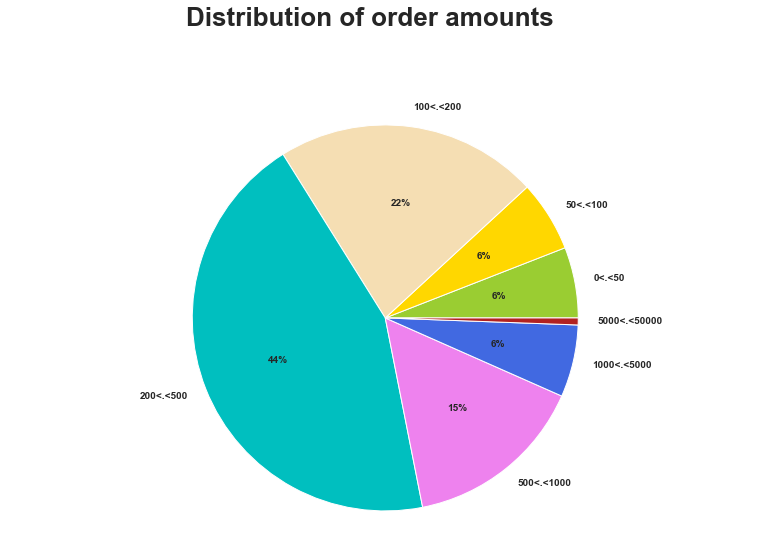

In [248]:
# Show distribution of basket prices in pie chart. 


# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Representation of the number of purchases / amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(12, 8))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 26);

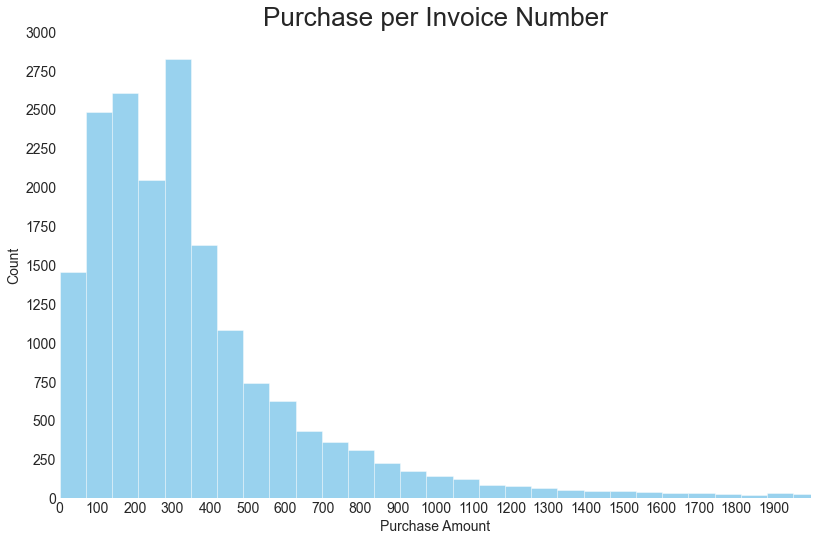

In [459]:
# Show distribution of basket prices HISTOGRAM. 
# WE will show Only basket price 0 - 2000 because there're not a lot basket prices > 2000

plt.figure(figsize = ( 12, 8))
sns.set_style('white')
sns.distplot(basket_price['Basket Price'], bins=400, kde = False)
plt.xlim(0,2000)
plt.ylim(0, 3000)
plt.xticks(np.arange(0, 2000, 100), fontsize = 14)
plt.title('Purchase per Invoice Number', fontsize = 26)
plt.yticks(np.arange(0, 3001, 250), fontsize = 14)
plt.xlabel('Purchase Amount', fontsize = 14)
plt.ylabel('Count', fontsize = 14)



sns.despine(left = True, bottom = True)

- Basket prices are right skewed but it's interesting to note a spike arounf 300, and a rise around 100. 
- Also note that a lot of purchases are > $200




____
## 3. Insight on product categories

In the dataframe, products are uniquely identified through the **StockCode** field, we cleaned this one in a previous step. A short description of the products is given in the **Description** field. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

___
### 3.1 Products Description

As a first step, I extract from the **Description** field the information that will prove useful. To do this, I use the following function:

In [250]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the **Description** column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [251]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [252]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1604


The execution of this function returns three values:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, I convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurences:

In [253]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

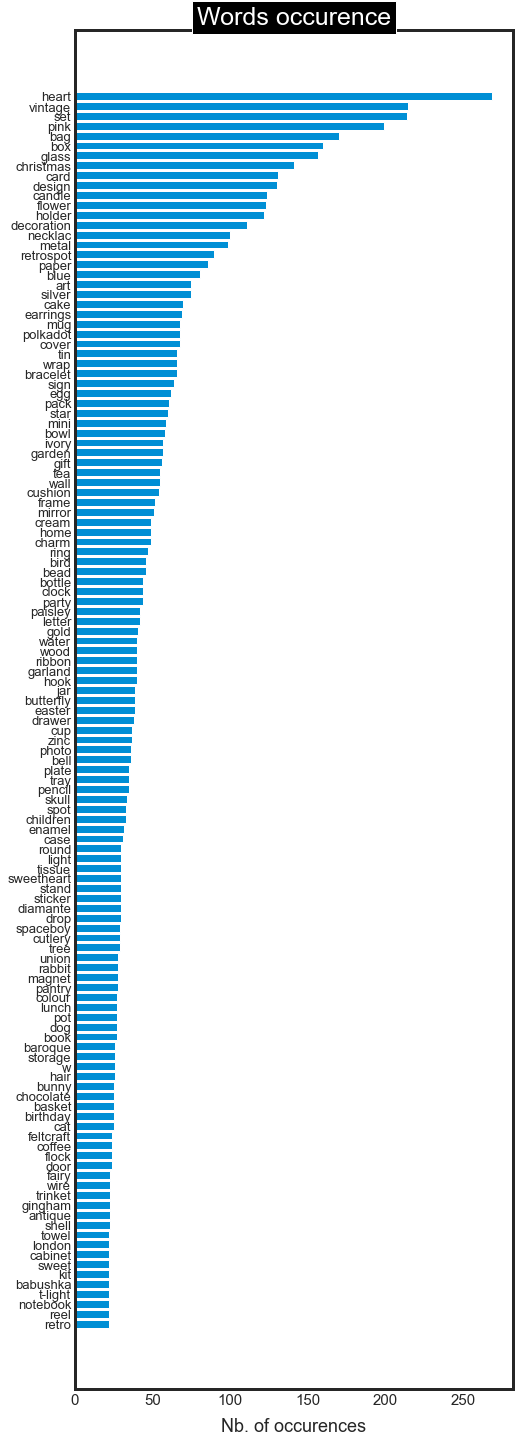

In [254]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### 3.2 Defining product categories 

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [34]:
# list_products = []
# for k,v in count_keywords.items():
#     word = keywords_select[k]
#     if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
#     if len(word) < 3 or v < 13: continue
#     if ('+' in word) or ('/' in word): continue
#     list_products.append([word, v])
# #______________________________________________________    
# list_products.sort(key = lambda x:x[1], reverse = True)
# print('preserved words:', len(list_products))

preserved words: 193


In [255]:
# use predefined list of stopwords from NLTK package
nltk_stopwords = set(stopwords.words('english'))
# basic function that removes matched stopwords from a dictionary object
def remove_stopwords(corpus: dict):
    temp_dict = {} # create a temporary dictionary
    tokens = keywords_select.keys()
    filtered_tokens = list(filter(lambda token: token not in nltk_stopwords, tokens)) # filter for stopwords
    for i in filtered_tokens: # update the temporary dictionary
        temp_dict.update({i: i})
    print(f'{len(keywords_select.keys())-len(temp_dict.keys())} stopwords removed')
    return temp_dict

In [256]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange',
               'box', 'sign', 'vintage', 'glass', 'light', 'candle', 'flower']: continue
    if len(word) < 5 or v < 13: continue # ovde sam promenio 3 u 5
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 128


In [200]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/markouskokovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/markouskokovic/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/markouskokovic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [257]:
# use predefined list of stopwords from NLTK package
nltk_stopwords = set(stopwords.words('english'))
# basic function that removes matched stopwords from a dictionary object
def remove_stopwords(corpus: dict):
    temp_dict = {} # create a temporary dictionary
    tokens = keywords_select.keys()
    filtered_tokens = list(filter(lambda token: token not in nltk_stopwords, tokens)) # filter for stopwords
    for i in filtered_tokens: # update the temporary dictionary
        temp_dict.update({i: i})
    print(f'{len(keywords_select.keys())-len(temp_dict.keys())} stopwords removed')
    return temp_dict

In [258]:
keywords_select = remove_stopwords(keywords_select) # also prints how many stopwords were removed

10 stopwords removed


In [259]:
# reflect the change on 'count_keywords' dict, too
count_keywords = {k: v for k, v in count_keywords.items() if k in keywords_select.keys()}

In [260]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange'\
                'box', 'sign', 'vintage', 'glass', 'light', 'candle', 'flower']: continue
    if len(word) < 5 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 124


____
#### 3.2.1 Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

   
|   | mot 1  |  ...  | mot j  | ...  | mot N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise. Here I have a row for each product and a column for each keyword. I fill in the entries with zero or 1, depending on whether that product has that keyword in its description.

In [261]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
X

,heart,vintag,christma,design,candl,holder,decor,necklac,metal,retrospot,...,wallet,alphabet,toadstool,funki,plant,diner,squar,craft,jewel,point
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3869,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [263]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:

In [264]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       963                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        150                 


____
#### 3.2.2 Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, a better metric for the calculation of distances is a dot product or [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). Note that the **kmeans** method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the [kmodes](https://pypi.python.org/pypi/kmodes/) package which is not available on the current plateform. Hence, I use the **kmeans** method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [266]:
# matrix = X.as_matrix()
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.1897173689219618
For n_clusters = 4 The average silhouette_score is : 0.2332614667621202
For n_clusters = 5 The average silhouette_score is : 0.2730908479477796
For n_clusters = 6 The average silhouette_score is : 0.2745032421111188
For n_clusters = 7 The average silhouette_score is : 0.264856875194775
For n_clusters = 8 The average silhouette_score is : 0.27382352926292797
For n_clusters = 9 The average silhouette_score is : 0.29300254540421533


- Usually we are looking for the highest silhouette score while assessing how many clusters of products we want. For our project we will move forward with 5 clusters.

In [271]:
# k means clustering gets different results each time you run it because of the random initialization, 
# so run it a few times and look for a particular run that has a silhouette score that's pretty good.

n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.273853681966918


___
#### 3.2.3  Characterizing the content of clusters

I check the number of elements in every class:

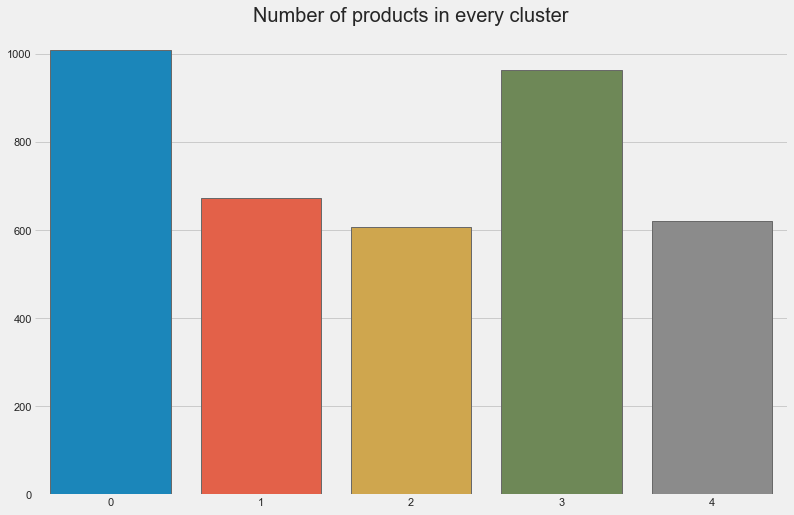

In [420]:
plt.figure(figsize = (12,8))

sns.barplot(pd.Series(clusters).value_counts().index, pd.Series(clusters).value_counts().values)

plt.title('Number of products in every cluster', fontsize = 20)

sns.despine(left = True, bottom = True)


** a / _Silhouette intra-cluster score_ **

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [277]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
#     plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

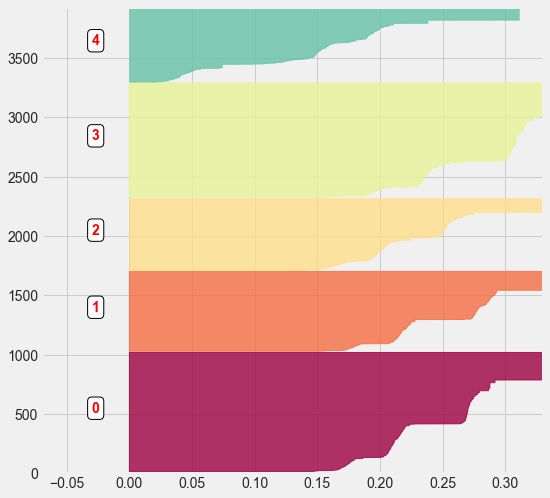

In [278]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

** b/ _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [279]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag',
                   'metal', 'holder', 'design', 'retro']: continue # made changes here
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

and I output the result as wordclouds:

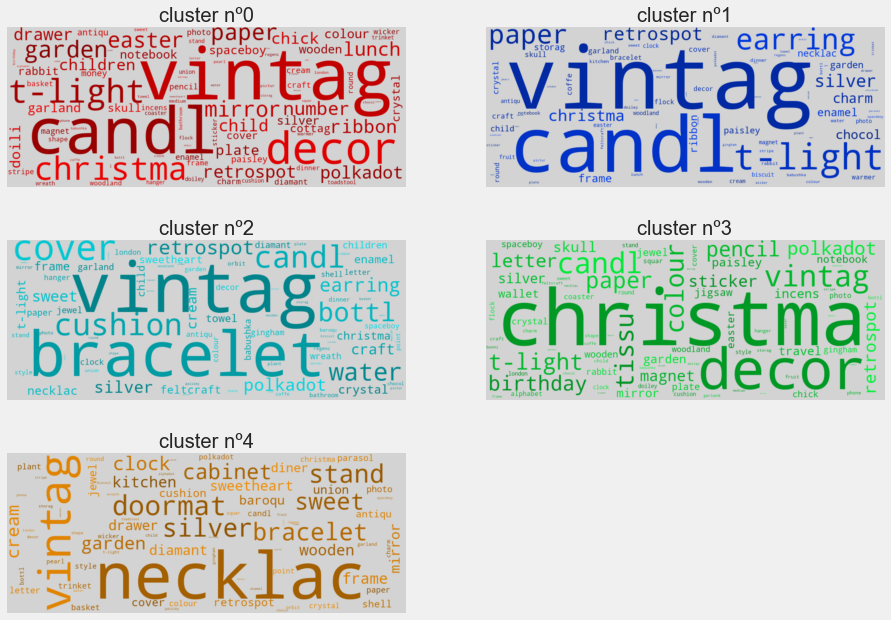

In [280]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

### This is segmentation based on products... we will need to analyse these and come up with names for each cluster.. 

- Let's see a few rows of each cluster to get a better idea of the products in clusters

In [281]:
prods=pd.DataFrame([liste_produits,clusters]).T
prods.columns=['prod','cluster']
prods['cluster'].value_counts()

0    1009
3     963
1     673
4     620
2     606
Name: cluster, dtype: int64

In [283]:
prods[prods['cluster']==0].head(10)

,prod,cluster
8,HAND WARMER RED POLKA DOT,0
9,ASSORTED COLOUR BIRD ORNAMENT,0
13,IVORY KNITTED MUG COSY,0
32,VINTAGE HEADS AND TAILS CARD GAME,0
35,SPACEBOY LUNCH BOX,0
36,LUNCH BOX I LOVE LONDON,0
37,CIRCUS PARADE LUNCH BOX,0
39,RED TOADSTOOL LED NIGHT LIGHT,0
47,RETRO COFFEE MUGS ASSORTED,0
48,SAVE THE PLANET MUG,0


In [284]:
prods[prods['cluster']==1].head(10)

,prod,cluster
0,WHITE HANGING HEART T-LIGHT HOLDER,1
7,HAND WARMER UNION JACK,1
10,POPPY'S PLAYHOUSE BEDROOM,1
11,POPPY'S PLAYHOUSE KITCHEN,1
34,ROUND SNACK BOXES SET OF4 WOODLAND,1
45,PAPER CHAIN KIT 50'S CHRISTMAS,1
53,WOODEN PICTURE FRAME WHITE FINISH,1
54,WOODEN FRAME ANTIQUE WHITE,1
57,RED HANGING HEART T-LIGHT HOLDER,1
58,JUMBO BAG PINK POLKADOT,1


In [285]:
prods[prods['cluster']==2].head(10)

,prod,cluster
1,WHITE METAL LANTERN,2
2,CREAM CUPID HEARTS COAT HANGER,2
3,KNITTED UNION FLAG HOT WATER BOTTLE,2
4,RED WOOLLY HOTTIE WHITE HEART.,2
6,GLASS STAR FROSTED T-LIGHT HOLDER,2
12,FELTCRAFT PRINCESS CHARLOTTE DOLL,2
14,BOX OF 6 ASSORTED COLOUR TEASPOONS,2
21,JAM MAKING SET WITH JARS,2
22,RED COAT RACK PARIS FASHION,2
23,YELLOW COAT RACK PARIS FASHION,2


In [286]:
prods[prods['cluster']==3].head(10)

,prod,cluster
29,PANDA AND BUNNIES STICKER SHEET,3
30,STARS GIFT TAPE,3
31,INFLATABLE POLITICAL GLOBE,3
38,CHARLOTTE BAG DOLLY GIRL DESIGN,3
42,MINI JIGSAW CIRCUS PARADE,3
43,MINI JIGSAW SPACEBOY,3
44,MINI PAINT SET VINTAGE,3
61,STRAWBERRY CHARLOTTE BAG,3
64,SET/6 RED SPOTTY PAPER PLATES,3
68,PACK OF 72 RETROSPOT CAKE CASES,3


In [287]:
prods[prods['cluster']==4].head(10)

,prod,cluster
5,SET 7 BABUSHKA NESTING BOXES,4
15,BOX OF VINTAGE JIGSAW BLOCKS,4
16,BOX OF VINTAGE ALPHABET BLOCKS,4
17,HOME BUILDING BLOCK WORD,4
18,LOVE BUILDING BLOCK WORD,4
19,RECIPE BOX WITH METAL HEART,4
20,DOORMAT NEW ENGLAND,4
25,BATH BUILDING BLOCK WORD,4
46,EDWARDIAN PARASOL RED,4
51,WOOD 2 DRAWER CABINET WHITE FINISH,4


___
## 4. Customer categories

### 4.1 Formatting data

In the previous section, the different products were grouped in 5 clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable **categ_product** where I indicate the cluster of each product :

In [289]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

___
#### 4.1.1 Grouping products

## Key idea is to have a table where for each invoiceNO we will have a breakdown of how much money is allocated for different clusters of products.. as a reminder, in the last step we created 5 clusters based on products, now it's time to match them with purchases

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

- here categ_# represents clusters so we will have categ_0...categ_4

In [292]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.3,0.00,0.0,0.0
1,536365,WHITE METAL LANTERN,2,0.0,0.0,20.34,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,2,0.0,0.0,22.00,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2,0.0,0.0,20.34,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2,0.0,0.0,20.34,0.0,0.0


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [293]:
#___________________________________________
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# order date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,187.2,83.40,293.35,23.40,124.44,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,130.5,53.10,169.20,84.34,38.25,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,330.9,71.10,115.00,81.00,38.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,74.4,78.06,168.76,41.40,19.90,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,109.7,119.70,158.16,61.30,136.05,2011-08-02 08:48:00.000000000


### Above is the table I was talking about with breakdown of money spent for each invoice per product segment


## 4.1.2. Consumer Order Combinations

#### group together the different entries that correspond to the same user. 

- number of purchases made by the user
- minimum 
- maximum
- average amounts
- total amount spent during all the visits
- Spending per product category
- first purchase
- last purchase
- canceled %
- unique products

In [343]:

# Group all relevent information together for each customer.
#________________________________________________________________
# number of visits and stats on the cart amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() / \
                                            transactions_per_user['sum']*100

df_cleaned['CanceledValue']=df_cleaned['QuantityCanceled']*df_cleaned['UnitPrice']
transactions_per_user=transactions_per_user.merge(
    df_cleaned[['CustomerID','CanceledValue']].groupby('CustomerID').sum(),
    left_index=True,right_index=True)
transactions_per_user['canceled%']=transactions_per_user['CanceledValue']/transactions_per_user['sum']*100
transactions_per_user['canceled%']=transactions_per_user['canceled%'].apply(lambda x: 100 if x>100 else x)

transactions_per_user=transactions_per_user.merge(
    df_cleaned[['Description','CustomerID']].groupby('CustomerID').nunique().\
    rename(columns={'Description':'unique_prod'}),
    left_index=True,right_index=True)

transactions_per_user.drop(columns='CanceledValue',inplace=True)
transactions_per_user.index.name = None
transactions_per_user.reset_index(drop = False, inplace = True)

transactions_per_user.drop(columns='CustomerID', inplace=True)
transactions_per_user.rename(columns={'index':'CustomerID'}, inplace=True)
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,canceled%,unique_prod
0,12347,7,224.82,1294.32,615.714286,4310.00,26.375870,20.805104,29.540371,11.237123,12.041531,0.000000,103
1,12348,4,187.44,652.80,359.310000,1437.24,52.461663,0.000000,0.000000,47.538337,0.000000,0.000000,21
2,12349,1,1457.55,1457.55,1457.550000,1457.55,31.961854,14.765874,12.918939,5.442009,34.911324,0.000000,72
3,12350,1,294.40,294.40,294.400000,294.40,55.027174,31.691576,0.000000,13.281250,0.000000,0.000000,16
4,12352,6,104.35,296.50,210.901667,1265.41,29.609376,7.675773,27.528627,2.449799,32.736425,9.509171,57


### First purchase & Last purchase

##### We will use this later again for RFM analysis

I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

In [344]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,canceled%,unique_prod,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,26.375870,20.805104,29.540371,11.237123,12.041531,0.000000,103,2,367
1,12348,4,187.44,652.80,359.310000,1437.24,52.461663,0.000000,0.000000,47.538337,0.000000,0.000000,21,75,358
2,12349,1,1457.55,1457.55,1457.550000,1457.55,31.961854,14.765874,12.918939,5.442009,34.911324,0.000000,72,18,18
3,12350,1,294.40,294.40,294.400000,294.40,55.027174,31.691576,0.000000,13.281250,0.000000,0.000000,16,310,310
4,12352,6,104.35,296.50,210.901667,1265.41,29.609376,7.675773,27.528627,2.449799,32.736425,9.509171,57,36,296


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

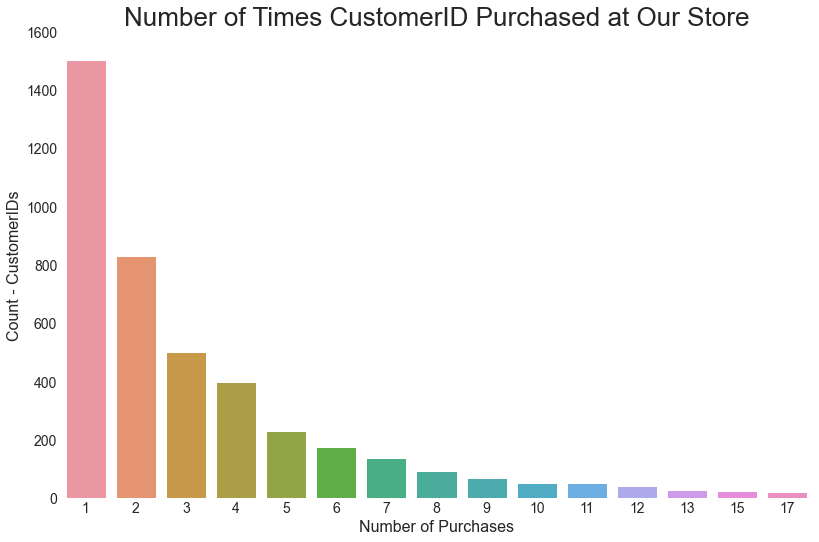

In [504]:


plt.figure(figsize = (12,8))
sns.set_style('white')
sns.barplot(transactions_per_user['count'].value_counts().index[:15], transactions_per_user['count'].value_counts().values[:15])
plt.ylim(0,1600)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Number of Purchases', fontsize = 16)
plt.ylabel('Count - CustomerIDs', fontsize = 16)

#plt.text(3, 1200, s = '1502/4324 (about 35%) CustomerIDs\nPurchased Just Once\n\n28', fontsize = 20)



plt.title('Number of Times CustomerID Purchased at Our Store', fontsize = 26)
sns.despine(left = True, bottom = True)


### We can see that a lot of customers bought from us just once... there's an opportunity to do something to make them come back to our store...

In [505]:
transactions_per_user[(transactions_per_user['count'] <= 3)].shape[0] / transactions_per_user.shape[0]

0.6558741905642923

In [347]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("number of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

number of customers with a single purchase: 1502/4324  (34.74%)


- A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed. Later we may want to redo the customer segmentation and put all these "one-time-buyers" into their own segment.

In [361]:
transactions_per_user.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,canceled%,unique_prod,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,26.375870,20.805104,29.540371,11.237123,12.041531,0.000000,103,2,367
1,12348,4,187.44,652.80,359.310000,1437.24,52.461663,0.000000,0.000000,47.538337,0.000000,0.000000,21,75,358
2,12349,1,1457.55,1457.55,1457.550000,1457.55,31.961854,14.765874,12.918939,5.442009,34.911324,0.000000,72,18,18
3,12350,1,294.40,294.40,294.400000,294.40,55.027174,31.691576,0.000000,13.281250,0.000000,0.000000,16,310,310
4,12352,6,104.35,296.50,210.901667,1265.41,29.609376,7.675773,27.528627,2.449799,32.736425,9.509171,57,36,296


___
### 4.2 # Customer Clustering

#### 4.2.1 Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [352]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4',
            'unique_prod', 'canceled%', 'LastPurchase', 'FirstPurchase']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [353]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.22641073 243.20878816 571.08224792 370.04821957  25.6564134
  21.89283534  17.16306247  14.26152072  21.02616807  61.87280296
   1.94377986  92.34759482 222.92599445]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [354]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

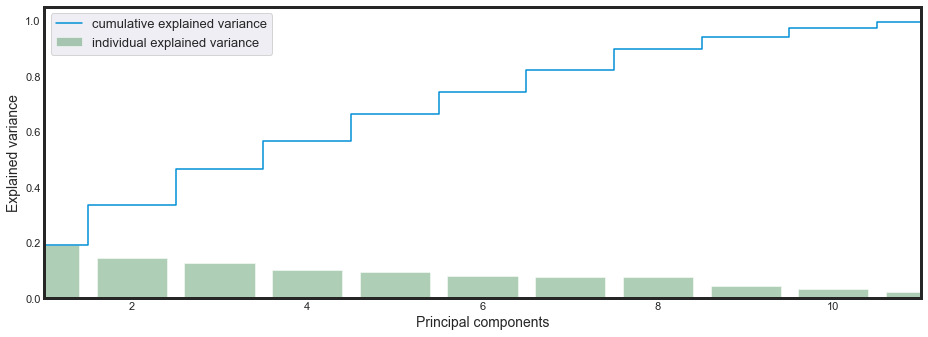

In [355]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

___
#### 4.2.2 Creation of customer categories

In [357]:
for n in range(6,12):
    kmeans = KMeans(init='k-means++', n_clusters = n, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    print('number of clusters is ',n, '  silhouette score: {:<.3f}'.format(silhouette_avg))
    print(pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T,'\n')

number of clusters is  6   silhouette score: 0.148
                   1     4    5    2   0   3
nb. de clients  1258  1224  919  836  51  36 

number of clusters is  7   silhouette score: 0.150
                   5     1    2    3   0   4   6
nb. de clients  1262  1218  916  838  52  22  16 

number of clusters is  8   silhouette score: 0.158
                   1     5    3    0    6   2   4   7
nb. de clients  1148  1043  958  729  361  47  22  16 

number of clusters is  9   silhouette score: 0.172
                   1     5    0    7    4    2   6   3   8
nb. de clients  1156  1070  695  667  355  297  46  22  16 

number of clusters is  10   silhouette score: 0.180
                   5     0    4    1    3    7    8   9   2   6
nb. de clients  1189  1119  626  460  329  260  254  49  22  16 

number of clusters is  11   silhouette score: 0.183
                  3     6    5    0    1    10   8   4   7   2   9 
nb. de clients  1214  1072  666  478  276  275  255  49  17  16   6 



### based on silhouette score and trying to keep a reasonable # of customer clusters, I recommend to move forward with 9 customer clusters.. 

### but should talk about this and determine what # of clusters is appropriate for further analysis

In [358]:
n_clusters = 9
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.171


At first, I look at the number of customers in each cluster:

In [359]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

,6,2,1,3,5,0,8,4,7
nb. de clients,1149,1072,697,671,350,297,50,22,16


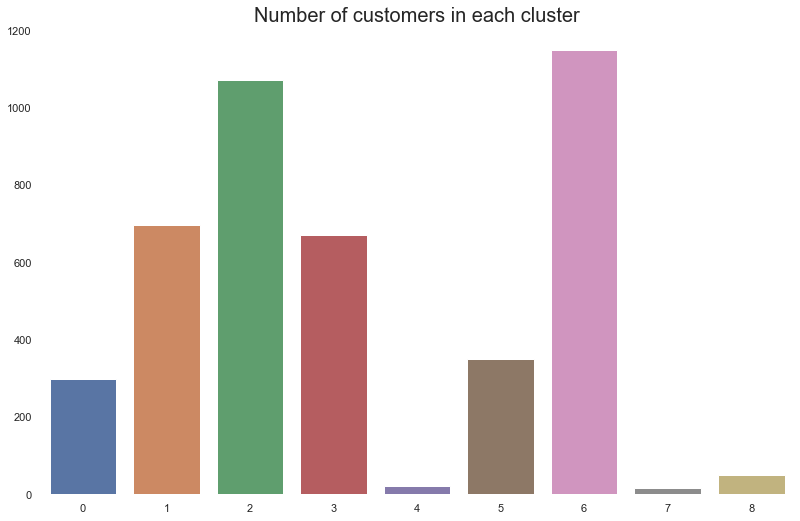

In [360]:
plt.figure(figsize = ( 12,8))
sns.set_style('white')
sns.barplot(pd.Series(clusters_clients).value_counts().index, pd.Series(clusters_clients).value_counts().values)

plt.title('Number of customers in each cluster', fontsize = 20)
sns.despine(left = True, bottom = True)

plt.show()

### After further analysis we can choose to delete clusters 4 and 7 and 8 because they have less then 50 customer together.. or we can join them to some other cluster.. 




** a / _Report via the PCA_ **

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [362]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

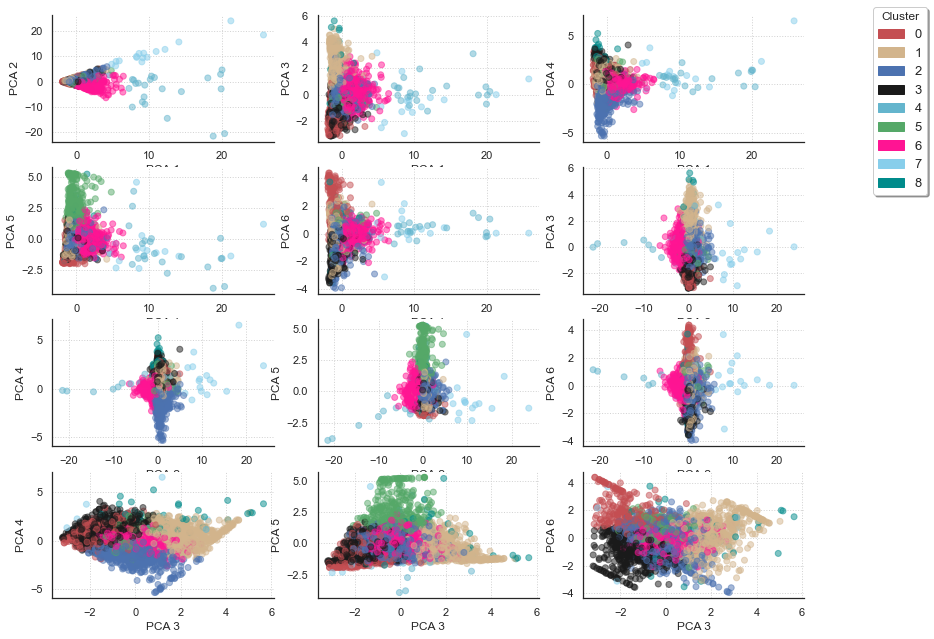

In [363]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()



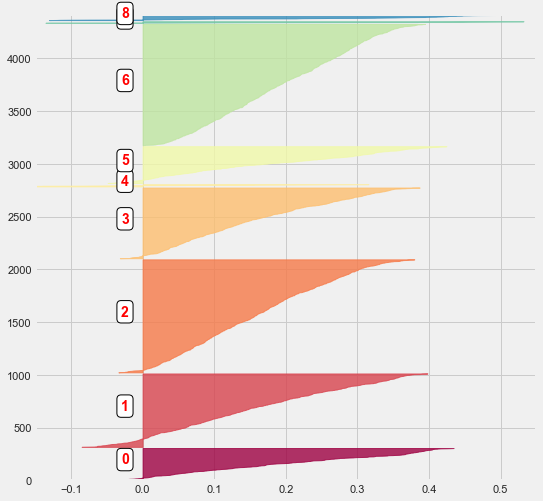

In [364]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

** c/ _Customers morphotype_**

At this stage, I have verified that the different clusters are reasonably disjoint (at least, in a global way). It remains to understand the behavior of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

In [369]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [370]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 4324


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [374]:
liste_index = []
focused_cols=['categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 
              'canceled%', 'unique_prod','sum']
for col in focused_cols:
    idx=merged_df[col].idxmax()
    if idx not in liste_index:
        liste_index.append(idx)
liste_index_reordered = liste_index.copy()
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df['cluster']=merged_df['cluster'].astype(int)
merged_df

,index,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,canceled%,unique_prod,LastPurchase,FirstPurchase,size
0,0,3,2.263785,235.139702,356.129106,292.468196,640.170253,52.463232,15.703024,9.114457,13.823553,8.895734,1.204396,31.312966,128.031297,208.199702,671
1,1,5,2.622857,236.284400,422.429629,323.705886,911.330200,15.251032,60.659390,7.918305,8.161073,8.010199,0.838103,23.485714,115.011429,221.660000,350
2,2,2,2.120336,297.859655,461.360000,372.852423,779.970718,21.846768,19.054624,28.847111,11.578397,18.673099,1.010153,42.691231,50.676306,106.137127,1072
3,3,0,2.212121,192.497879,323.272391,247.830466,570.585017,20.708817,11.808626,6.318616,53.940076,7.223867,0.598458,28.740741,104.164983,184.956229,297
4,4,1,2.083214,251.100617,350.182324,296.705128,593.189484,13.923209,14.623759,15.312011,6.718139,49.422882,1.347177,25.807747,205.279770,270.077475,697
5,5,8,2.880000,136.191800,443.296800,272.654878,981.793000,22.960132,23.342722,13.320140,13.854452,26.522555,65.155874,35.540000,139.260000,263.280000,50
6,6,4,61.272727,50.250455,10585.610000,2180.135152,84631.040909,22.605752,28.222479,17.371736,10.414886,21.385148,4.343805,584.545455,7.454545,352.454545,22
7,7,6,8.653612,161.039060,783.369147,409.189382,3537.653516,25.317218,23.171989,17.892774,13.268316,20.349703,1.450851,130.694517,31.071366,318.893821,1149
8,8,7,1.312500,4169.561875,5796.270625,4917.752708,6800.960625,24.255873,22.373679,15.355527,15.806489,22.208432,5.214049,75.812500,123.625000,147.937500,16


** d / _Customers morphology_ **

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave -read-this)):

In [375]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


This allows to have a global view of the content of each cluster:

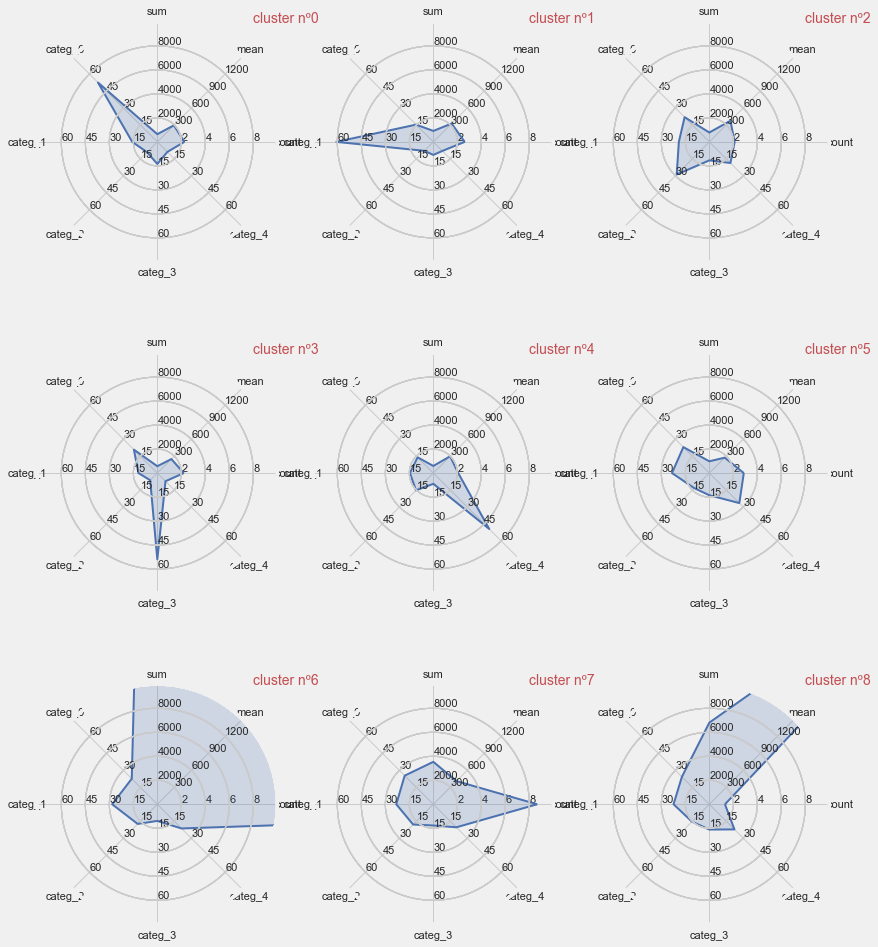

In [376]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

## This radar chart will be valuable in determining business interpretation for customer clusters

# 5

# RFM analysis

## This RFM analysis will have 2 parts:

### Firstly, we will perform RFM on CustomerID level, so we have RFM score for each customer

### Secondly, we will perform RFM on Customer Cluster level so we have RFM score for each cluster

In [381]:
transactions_per_user

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,canceled%,unique_prod,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,26.375870,20.805104,29.540371,11.237123,12.041531,0.000000,103,2,367
1,12348,4,187.44,652.80,359.310000,1437.24,52.461663,0.000000,0.000000,47.538337,0.000000,0.000000,21,75,358
2,12349,1,1457.55,1457.55,1457.550000,1457.55,31.961854,14.765874,12.918939,5.442009,34.911324,0.000000,72,18,18
3,12350,1,294.40,294.40,294.400000,294.40,55.027174,31.691576,0.000000,13.281250,0.000000,0.000000,16,310,310
4,12352,6,104.35,296.50,210.901667,1265.41,29.609376,7.675773,27.528627,2.449799,32.736425,9.509171,57,36,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,18280,1,180.60,180.60,180.600000,180.60,0.000000,41.140642,24.833887,0.000000,34.025471,0.000000,10,277,277
4320,18281,1,80.82,80.82,80.820000,80.82,20.415739,18.930958,0.000000,18.708241,41.945063,0.000000,7,180,180
4321,18282,2,77.84,98.76,88.300000,176.60,12.995470,20.045300,24.405436,13.674972,28.878822,0.821065,12,7,126
4322,18283,16,1.95,307.05,127.473750,2039.58,33.633395,41.693388,5.631061,16.355328,2.686828,0.000000,271,3,337


# RFM on CustomerID level

# for RFM analysis we will need

- CustomerID
- Last Purchase (min recency)
- First Purchase (max recency)
- count (frequency)
- sum (monetary value)



In [382]:
rmf = transactions_per_user[['CustomerID', 'LastPurchase', 'FirstPurchase', 'count', 'sum']]

In [384]:
rmf.head()

,CustomerID,LastPurchase,FirstPurchase,count,sum
0,12347,2,367,7,4310.00
1,12348,75,358,4,1437.24
2,12349,18,18,1,1457.55
3,12350,310,310,1,294.40
4,12352,36,296,6,1265.41


# Key idea is to have 1-4  score for each customerID when it comes to Recency, Frequency and Monetary value.

### note that 1 represent the best score and 4 the worst

In [385]:
quantiles = rmf.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [386]:
segmented_rfm = rmf

In [387]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [389]:
segmented_rfm['r_quartile'] = segmented_rfm['LastPurchase'].apply(RScore, args=('LastPurchase',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['count'].apply(FMScore, args=('count',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['sum'].apply(FMScore, args=('sum',quantiles,))
segmented_rfm.head()

,CustomerID,LastPurchase,FirstPurchase,count,sum,r_quartile,f_quartile,m_quartile
0,12347,2,367,7,4310.00,1,1,1
1,12348,75,358,4,1437.24,3,2,2
2,12349,18,18,1,1457.55,2,4,2
3,12350,310,310,1,294.40,4,4,4
4,12352,36,296,6,1265.41,2,1,2


## Now that we have individual values for RFM, let's group them together in RFMScore column

In [390]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,CustomerID,LastPurchase,FirstPurchase,count,sum,r_quartile,f_quartile,m_quartile,RFMScore
0,12347,2,367,7,4310.00,1,1,1,111
1,12348,75,358,4,1437.24,3,2,2,322
2,12349,18,18,1,1457.55,2,4,2,242
3,12350,310,310,1,294.40,4,4,4,444
4,12352,36,296,6,1265.41,2,1,2,212


## Let's see who are the customers with 111 score..that's the best RFM score or in other words that's our best customers

In [547]:
segmented_rfm[segmented_rfm['RFMScore']=='223'].sort_values('sum', ascending=False).head(10)

,CustomerID,LastPurchase,FirstPurchase,count,sum,r_quartile,f_quartile,m_quartile,RFMScore
2936,16362,32,91,5,650.59,2,2,3,223
3382,16969,39,191,3,650.41,2,2,3,223
3075,16554,42,331,3,648.35,2,2,3,223
3959,17777,24,100,3,647.56,2,2,3,223
3658,17373,40,312,4,646.92,2,2,3,223
1244,14044,26,309,4,646.42,2,2,3,223
2420,15651,36,260,3,646.30,2,2,3,223
3786,17545,43,43,3,642.32,2,2,3,223
3764,17515,31,318,4,639.02,2,2,3,223
2680,16014,37,291,3,637.58,2,2,3,223


In [556]:
segmented_rfm.sort_values('sum', ascending=False).head(250)['sum'].sum()

4195224.45

In [511]:
segmented_rfm['sum'].sum()

8252117.049999999

In [532]:
segmented_rfm[segmented_rfm['RFMScore'].isin(['111', '211', '121', '311', '321', '231', '131', '411'
                                             ,'421', '431', '241', '341'])].shape

(963, 9)

In [540]:
segmented_rfm[segmented_rfm['RFMScore'].isin(['412'])]

,CustomerID,LastPurchase,FirstPurchase,count,sum,r_quartile,f_quartile,m_quartile,RFMScore
406,12868,185,373,6,1607.06,4,1,2,412
1632,14573,179,372,8,1590.12,4,1,2,412
2313,15508,189,235,6,1000.27,4,1,2,412
2370,15581,156,366,10,717.43,4,1,2,412
3198,16725,302,371,6,750.87,4,1,2,412
4023,17874,185,255,6,658.26,4,1,2,412
4235,18168,176,372,6,1150.29,4,1,2,412


In [529]:
segmented_rfm

,CustomerID,LastPurchase,FirstPurchase,count,sum,r_quartile,f_quartile,m_quartile,RFMScore
0,12347,2,367,7,4310.00,1,1,1,111
1,12348,75,358,4,1437.24,3,2,2,322
2,12349,18,18,1,1457.55,2,4,2,242
3,12350,310,310,1,294.40,4,4,4,444
4,12352,36,296,6,1265.41,2,1,2,212
...,...,...,...,...,...,...,...,...,...
4319,18280,277,277,1,180.60,4,4,4,444
4320,18281,180,180,1,80.82,4,4,4,444
4321,18282,7,126,2,176.60,1,3,4,134
4322,18283,3,337,16,2039.58,1,1,1,111


# # RFM on Customer Cluster level

In [394]:
merged_df

,index,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,canceled%,unique_prod,LastPurchase,FirstPurchase,size
0,0,3,2.263785,235.139702,356.129106,292.468196,640.170253,52.463232,15.703024,9.114457,13.823553,8.895734,1.204396,31.312966,128.031297,208.199702,671
1,1,5,2.622857,236.284400,422.429629,323.705886,911.330200,15.251032,60.659390,7.918305,8.161073,8.010199,0.838103,23.485714,115.011429,221.660000,350
2,2,2,2.120336,297.859655,461.360000,372.852423,779.970718,21.846768,19.054624,28.847111,11.578397,18.673099,1.010153,42.691231,50.676306,106.137127,1072
3,3,0,2.212121,192.497879,323.272391,247.830466,570.585017,20.708817,11.808626,6.318616,53.940076,7.223867,0.598458,28.740741,104.164983,184.956229,297
4,4,1,2.083214,251.100617,350.182324,296.705128,593.189484,13.923209,14.623759,15.312011,6.718139,49.422882,1.347177,25.807747,205.279770,270.077475,697
5,5,8,2.880000,136.191800,443.296800,272.654878,981.793000,22.960132,23.342722,13.320140,13.854452,26.522555,65.155874,35.540000,139.260000,263.280000,50
6,6,4,61.272727,50.250455,10585.610000,2180.135152,84631.040909,22.605752,28.222479,17.371736,10.414886,21.385148,4.343805,584.545455,7.454545,352.454545,22
7,7,6,8.653612,161.039060,783.369147,409.189382,3537.653516,25.317218,23.171989,17.892774,13.268316,20.349703,1.450851,130.694517,31.071366,318.893821,1149
8,8,7,1.312500,4169.561875,5796.270625,4917.752708,6800.960625,24.255873,22.373679,15.355527,15.806489,22.208432,5.214049,75.812500,123.625000,147.937500,16


In [413]:
rmf_cust_clusters = merged_df[['cluster', 'LastPurchase', 'FirstPurchase', 'count', 'sum']]

In [415]:
rmf_cust_clusters

,cluster,LastPurchase,FirstPurchase,count,sum
0,3,128.031297,208.199702,2.263785,640.170253
1,5,115.011429,221.660000,2.622857,911.330200
2,2,50.676306,106.137127,2.120336,779.970718
3,0,104.164983,184.956229,2.212121,570.585017
4,1,205.279770,270.077475,2.083214,593.189484
5,8,139.260000,263.280000,2.880000,981.793000
6,4,7.454545,352.454545,61.272727,84631.040909
7,6,31.071366,318.893821,8.653612,3537.653516
8,7,123.625000,147.937500,1.312500,6800.960625


In [416]:
segmented_rfm_clusters = rmf_cust_clusters

In [417]:
segmented_rfm_clusters['r_quartile'] = segmented_rfm_clusters['LastPurchase'].apply(RScore, args=('LastPurchase',quantiles,))
segmented_rfm_clusters['f_quartile'] = segmented_rfm_clusters['count'].apply(FMScore, args=('count',quantiles,))
segmented_rfm_clusters['m_quartile'] = segmented_rfm_clusters['sum'].apply(FMScore, args=('sum',quantiles,))
segmented_rfm_clusters.head()

,cluster,LastPurchase,FirstPurchase,count,sum,r_quartile,f_quartile,m_quartile
0,3,128.031297,208.199702,2.263785,640.170253,3,2,3
1,5,115.011429,221.660000,2.622857,911.330200,3,2,2
2,2,50.676306,106.137127,2.120336,779.970718,3,2,2
3,0,104.164983,184.956229,2.212121,570.585017,3,2,3
4,1,205.279770,270.077475,2.083214,593.189484,4,2,3


## Now that we have individual values for RFM, let's group them together in RFMScore column

In [419]:
segmented_rfm_clusters['RFMScore'] = segmented_rfm_clusters.r_quartile.map(str) + segmented_rfm_clusters.f_quartile.map(str) + segmented_rfm_clusters.m_quartile.map(str)
segmented_rfm_clusters

,cluster,LastPurchase,FirstPurchase,count,sum,r_quartile,f_quartile,m_quartile,RFMScore
0,3,128.031297,208.199702,2.263785,640.170253,3,2,3,323
1,5,115.011429,221.660000,2.622857,911.330200,3,2,2,322
2,2,50.676306,106.137127,2.120336,779.970718,3,2,2,322
3,0,104.164983,184.956229,2.212121,570.585017,3,2,3,323
4,1,205.279770,270.077475,2.083214,593.189484,4,2,3,423
5,8,139.260000,263.280000,2.880000,981.793000,3,2,2,322
6,4,7.454545,352.454545,61.272727,84631.040909,1,1,1,111
7,6,31.071366,318.893821,8.653612,3537.653516,2,1,1,211
8,7,123.625000,147.937500,1.312500,6800.960625,3,3,1,331


# example of top 20 products for product clusters

# Product Cluster 0 

In [423]:
df_cleaned[df_cleaned['categ_product'] == 0]['Description'].value_counts().sort_values(ascending = False)[:20]

ASSORTED COLOUR BIRD ORNAMENT         1395
LUNCH BAG RED RETROSPOT               1303
LUNCH BAG  BLACK SKULL.               1078
LUNCH BAG SPACEBOY DESIGN              993
HEART OF WICKER SMALL                  979
LUNCH BAG CARS BLUE                    977
LUNCH BAG PINK POLKADOT                941
LUNCH BAG SUKI DESIGN                  915
SET OF 4 PANTRY JELLY MOULDS           881
LUNCH BAG APPLE DESIGN                 878
JAM MAKING SET PRINTED                 870
LUNCH BAG WOODLAND                     831
VICTORIAN GLASS HANGING T-LIGHT        819
GARDENERS KNEELING PAD KEEP CALM       762
6 RIBBONS RUSTIC CHARM                 741
SPACEBOY LUNCH BOX                     709
LUNCH BAG ALPHABET DESIGN              660
CLOTHES PEGS RETROSPOT PACK 24         642
GARDENERS KNEELING PAD CUP OF TEA      642
DOLLY GIRL LUNCH BOX                   623
Name: Description, dtype: int64

# Product Cluster 1

In [425]:
df_cleaned[df_cleaned['categ_product'] == 1]['Description'].value_counts().sort_values(ascending = False)[:20]

WHITE HANGING HEART T-LIGHT HOLDER     2016
JUMBO BAG RED RETROSPOT                1615
PAPER CHAIN KIT 50'S CHRISTMAS         1003
NATURAL SLATE HEART CHALKBOARD          972
JUMBO BAG PINK POLKADOT                 884
WOODEN PICTURE FRAME WHITE FINISH       882
RECIPE BOX PANTRY YELLOW DESIGN         836
RABBIT NIGHT LIGHT                      823
WOODEN FRAME ANTIQUE WHITE              816
HEART OF WICKER LARGE                   811
JUMBO SHOPPER VINTAGE RED PAISLEY       793
ROSES REGENCY TEACUP AND SAUCER         791
JUMBO STORAGE BAG SUKI                  780
JUMBO BAG VINTAGE LEAF                  779
SET/5 RED RETROSPOT LID GLASS BOWLS     773
JUMBO BAG ALPHABET                      757
JUMBO BAG APPLES                        724
PAPER CHAIN KIT VINTAGE CHRISTMAS       706
PLEASE ONE PERSON METAL SIGN            705
GREEN REGENCY TEACUP AND SAUCER         700
Name: Description, dtype: int64

# Product Cluster 2

In [426]:
df_cleaned[df_cleaned['categ_product'] == 2]['Description'].value_counts().sort_values(ascending = False)[:20]

PARTY BUNTING                        1390
SET OF 3 CAKE TINS PANTRY DESIGN     1152
SPOTTY BUNTING                       1014
ALARM CLOCK BAKELIKE RED              886
JAM MAKING SET WITH JARS              880
BAKING SET 9 PIECE RETROSPOT          858
RETROSPOT TEA SET CERAMIC 11 PC       825
ALARM CLOCK BAKELIKE GREEN            797
HOT WATER BOTTLE KEEP CALM            731
SET OF 3 REGENCY CAKE TINS            721
CHOCOLATE HOT WATER BOTTLE            706
SET OF 6 SPICE TINS PANTRY DESIGN     663
SCOTTIE DOG HOT WATER BOTTLE          661
ALARM CLOCK BAKELIKE PINK             619
RETROSPOT HEART HOT WATER BOTTLE      541
GREY HEART HOT WATER BOTTLE           531
HOT WATER BOTTLE TEA AND SYMPATHY     516
HOT WATER BOTTLE I AM SO POORLY       507
ALARM CLOCK BAKELIKE IVORY            470
CREAM HEART CARD HOLDER               454
Name: Description, dtype: int64

# Product Cluster 3

In [427]:
df_cleaned[df_cleaned['categ_product'] == 3]['Description'].value_counts().sort_values(ascending = False)[:20]

PACK OF 72 RETROSPOT CAKE CASES        1050
REX CASH+CARRY JUMBO SHOPPER            897
RED RETROSPOT CHARLOTTE BAG             748
SET/20 RED RETROSPOT PAPER NAPKINS      746
VINTAGE SNAP CARDS                      731
PACK OF 60 PINK PAISLEY CAKE CASES      676
60 TEATIME FAIRY CAKE CASES             672
POPCORN HOLDER                          653
CHARLOTTE BAG SUKI DESIGN               590
PACK OF 20 NAPKINS PANTRY DESIGN        554
PACK OF 60 DINOSAUR CAKE CASES          543
WOODLAND CHARLOTTE BAG                  538
COLOUR GLASS T-LIGHT HOLDER HANGING     530
SET OF 60 PANTRY DESIGN CAKE CASES      516
72 SWEETHEART FAIRY CAKE CASES          515
PACK OF 72 SKULL CAKE CASES             505
SET OF 20 VINTAGE CHRISTMAS NAPKINS     502
STRAWBERRY CHARLOTTE BAG                496
CHARLOTTE BAG PINK POLKADOT             494
60 CAKE CASES VINTAGE CHRISTMAS         479
Name: Description, dtype: int64

# Product Cluster 4 

In [428]:
df_cleaned[df_cleaned['categ_product'] == 4]['Description'].value_counts().sort_values(ascending = False)[:20]

REGENCY CAKESTAND 3 TIER              1714
HOME BUILDING BLOCK WORD               695
DOORMAT KEEP CALM AND COME IN          652
IVORY KITCHEN SCALES                   620
WOOD BLACK BOARD ANT WHITE FINISH      604
DOORMAT RED RETROSPOT                  577
LOVE BUILDING BLOCK WORD               560
DOORMAT NEW ENGLAND                    533
CHILLI LIGHTS                          521
DOORMAT UNION FLAG                     518
WOOD 2 DRAWER CABINET WHITE FINISH     512
DOORMAT HEARTS                         481
LOVE HOT WATER BOTTLE                  459
CREAM SWEETHEART MINI CHEST            450
RED KITCHEN SCALES                     449
ENAMEL FLOWER JUG CREAM                444
BAKING SET SPACEBOY DESIGN             427
RED RETROSPOT CAKE STAND               422
RED DINER WALL CLOCK                   416
DOORMAT SPOTTY HOME SWEET HOME         405
Name: Description, dtype: int64

Acknowledgements:

Kaggle:

[F. Daniel](https://www.kaggle.com/fabiendaniel/customer-segmentation)


[Miljan Stojiljkovic](https://www.kaggle.com/miljan/customer-segmentation)


[J. Abécassis](https://www.kaggle.com/judithabk6) 


Data Cleaning:

Thanks to all MSBA students who tried to improve this notebook!